In [1]:
import time
# science
import numpy as np
import torch
from einops import repeat, rearrange

In [2]:
import joblib
import sidechainnet

In [3]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [5]:
min_len = 100
for batch in dataloaders['train']:
    real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
    print("seq len", len(real_seqs[0]))
    try:
        for i in range(len(batch.int_seqs.numpy())):
            # get variables
            seq     = real_seqs[i]
            int_seq = batch.int_seqs[i]
            angles  = batch.angs[i]
            # get padding
            padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
            padding_seq    = (np.array([x for x in seq]) == "_").sum()
            # only accept sequences with right dimensions and no missing coords
            # if padding_seq == padding_angles:
            # print("paddings_match")
            # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
            
            # to retrieve the 112: and batch.pids[i] == "2F2H_d2f2hf1":
            if list(batch.crds[i].shape)[0]//14 == len(int_seq): #  
                if len(seq) > min_len and padding_seq == padding_angles:
                    print("stopping at sequence of length", len(seq))
                    print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                    print("paddings: ", padding_seq, padding_angles)
                    raise StopIteration
                else:
                    print("found a seq of length:", len(seq), "but below the threshold:", min_len)
    except StopIteration:
        break

seq len 158
stopping at sequence of length 158
158 torch.Size([158, 12]) tensor(False)
paddings:  7 tensor(7)


### Load joblib file

In [6]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#              "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/112_aas_seq_and_angles.joblib")
info = joblib.load("experiments/112_aas_seq_and_angles.joblib")
seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
padding_seq    = (np.array([x for x in seq]) == "_").sum()

### Load algo

In [7]:
from massive_pnerf import *

In [8]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [16]:
# featurize
scaffolds  = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq]) # .double())
# convert to double
scaffolds_ = scaffolds
scaffolds_["angles_mask"] = scaffolds_["angles_mask"]# .double() 
scaffolds_["bond_mask"]   = scaffolds_["bond_mask"]# .double() 

In [10]:
# %%timeit
n_iters = 1001
errors, errors_3d  = [], []
coords_wrapper = true_coords[:].double()
# do n times and check error
for i in range(n_iters):
    # modify scaffolds with true data
    scaffolds_ = modify_scaffolds_with_coords(scaffolds_.copy(), 
                                              rearrange(coords_wrapper, '(l c) d -> l c d', c=14)[:-padding_seq])
    # scaffolds_ = scaffolds.copy()
    
    ## convert scaffolds to double

    # convert coords - fold
    coords, mask = proto_fold(seq[:-padding_seq], **scaffolds_)
    coords_flat  = rearrange(coords, 'l c d -> (l c) d')
    
    
    # align i first iter
    flat_mask = rearrange(scaffolds_["cloud_mask"], 'l c -> (l c)')
    coords_aligned_pre, labels_aligned_pre = kabsch_torch(coords_flat[flat_mask].t(),
                                                          true_coords[:].double()[:-14*padding_angles][flat_mask].t())

    # create coord scaffolds
    scaff_coords_aligned = torch.zeros_like(coords_flat)
    scaff_labels_aligned = torch.zeros_like(coords_flat)
    # fill
    scaff_coords_aligned[flat_mask] = coords_aligned_pre.t()
    scaff_labels_aligned[flat_mask] = labels_aligned_pre.t()
    # replace vars
    coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned
        
    # record evolution
    errors.append(rmsd_torch(coords_aligned, labels_aligned).item())
    errors_3d.append( (coords_aligned - labels_aligned).abs().mean(dim=-2) ) # [0])
    if i % 100 == 0 or i in [1,2,3,4,5]:
        print(i, "RMSD is:", errors[-1], "|| abs_error in 3 axis:", errors_3d[-1])
    
    # update coords
    coords_wrapper = torch.zeros_like( rearrange(coords_wrapper, '(l c) d -> l c d', c=14) )
    coords_wrapper[:-padding_angles] = rearrange(coords_flat, '(l c) d -> l c d', c=14)
    coords_wrapper = rearrange(coords_wrapper, 'l c d -> (l c) d')
    

0 RMSD is: 0.013866866296178754 || abs_error in 3 axis: tensor([0.0086, 0.0078, 0.0082], dtype=torch.float64)
1 RMSD is: 0.011569061968195373 || abs_error in 3 axis: tensor([0.0077, 0.0079, 0.0038], dtype=torch.float64)
2 RMSD is: 0.017925721371184197 || abs_error in 3 axis: tensor([0.0158, 0.0081, 0.0074], dtype=torch.float64)
3 RMSD is: 0.016289637920275477 || abs_error in 3 axis: tensor([0.0067, 0.0140, 0.0082], dtype=torch.float64)
4 RMSD is: 0.012404540249890222 || abs_error in 3 axis: tensor([0.0082, 0.0078, 0.0065], dtype=torch.float64)
5 RMSD is: 0.015752604978525587 || abs_error in 3 axis: tensor([0.0069, 0.0138, 0.0065], dtype=torch.float64)
100 RMSD is: 0.008022129371580382 || abs_error in 3 axis: tensor([0.0056, 0.0044, 0.0044], dtype=torch.float64)
200 RMSD is: 0.008147681661344946 || abs_error in 3 axis: tensor([0.0055, 0.0046, 0.0044], dtype=torch.float64)
300 RMSD is: 0.008147681661257145 || abs_error in 3 axis: tensor([0.0055, 0.0046, 0.0044], dtype=torch.float64)
400 

### Debug

In [11]:
import matplotlib.pyplot as plt

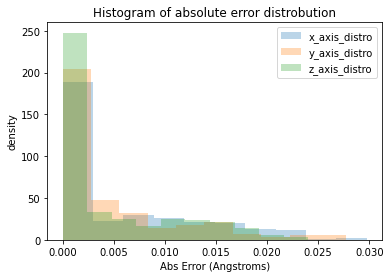

In [12]:
plt.title("Histogram of absolute error distrobution")
plt.hist( (coords_aligned - labels_aligned).abs().numpy()[:, 0], alpha=0.3, density=True, label="x_axis_distro")
plt.hist( (coords_aligned - labels_aligned).abs().numpy()[:, 1], alpha=0.3, density=True, label="y_axis_distro")
plt.hist( (coords_aligned - labels_aligned).abs().numpy()[:, 2], alpha=0.3, density=True, label="z_axis_distro")
plt.legend()
plt.ylabel("density")
plt.xlabel("Abs Error (Angstroms)")
plt.show()

In [13]:
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_aligned) 
sb.to_pdb("preds/predicted_112.pdb")
sb = sidechainnet.StructureBuilder(int_seq, crd=labels_aligned) 
sb.to_pdb("preds/labels_112.pdb")

### Make cool plot

In [14]:
joblib.dump({"rmsd": errors, "axis_abs": torch.stack(errors_3d, dim=0)}, "experiments/looping_error.joblib")
data = joblib.load("experiments/looping_error.joblib")

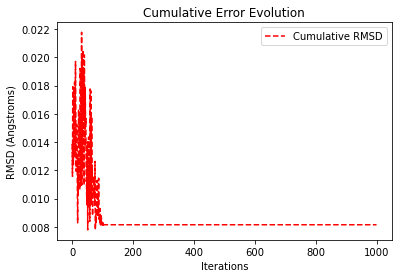

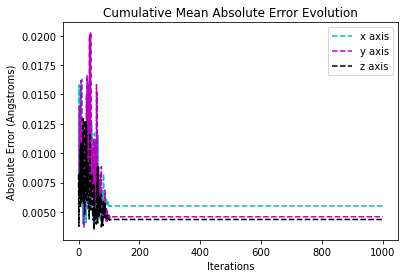

In [15]:
# RMSD
plt.title("Cumulative Error Evolution")
plt.plot(errors, 'r--', label="Cumulative RMSD")
plt.ylabel("RMSD (Angstroms)")
plt.xlabel("Iterations")
plt.legend()
plt.show()

# 3d axis ABS ERROR
plt.title("Cumulative Mean Absolute Error Evolution")
plt.plot(data["axis_abs"][:, 0].numpy(), 'c--', label="x axis")
plt.plot(data["axis_abs"][:, 1].numpy(), 'm--', label="y axis")
plt.plot(data["axis_abs"][:, 2].numpy(), 'k--', label="z axis")
plt.ylabel("Absolute Error (Angstroms)")
plt.xlabel("Iterations")
plt.legend()
plt.show()